In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np # For plotting and meshgrid
from mpl_toolkits.mplot3d import Axes3D # For 3D plotting

DEVICE = torch.device('cpu')

# (Optional) Set a seed for reproducibility
# torch.manual_seed(42)
# if torch.cuda.is_available():
#   torch.cuda.manual_seed_all(42)

def construct_model(
  arch,
  train_embed_layer,
  act,
  width,
  hid_n_layers,
):
  # arch : "MLP", "ResNet", "DiffNet-Add", "DiffNet-Mul"
  # train_embed_layer : bool, whether to train the first layer
  # act : "tanh", "sin", "relu", "gelu"
  # width : int, number of hidden units in each layer
  # hid_n_layers : int, number of hidden layers
  if arch == "MLP":
    return MLP(
      act=act,
      train_embed_layer=train_embed_layer,
      width=width,
      hid_n_layers=hid_n_layers,
      residual=False
    )
  elif arch == "ResNet":
    return MLP(
      act=act,
      train_embed_layer=train_embed_layer,
      width=width,
      hid_n_layers=hid_n_layers,
      residual=True
    )
  elif arch == "DiffNet-Add":
    return DiffNet(
      act=act,
      train_embed_layer=train_embed_layer,
      width=width,
      hid_n_layers=hid_n_layers,
      scale_type='add'
    )
  elif arch == "DiffNet-Mul":
    return DiffNet(
      act=act,
      train_embed_layer=train_embed_layer,
      width=width,
      hid_n_layers=hid_n_layers,
      scale_type='mul'
    )
  elif arch.startswith("DiffNet-Const"):
    return DiffNet(
      act=act,
      train_embed_layer=train_embed_layer,
      width=width,
      hid_n_layers=hid_n_layers,
      scale_type='const',
      scale_const=float(arch.split('-')[-1]) if '-' in arch else 1.0
    )

class MLP(nn.Module):
  
  def __init__(self,
    act='relu',
    train_embed_layer=False,
    width=64,
    hid_n_layers=2,
    residual=False
  ):
    super(MLP, self).__init__()
    self.train_embed_layer = train_embed_layer
    self.width = width
    self.hid_n_layers = hid_n_layers
    self.residual = residual

    if act.lower() == 'relu':
      self.act = nn.ReLU()
    elif act.lower() == 'gelu':
      self.act = nn.GELU()
    elif act.lower() == 'tanh':
      self.act = nn.Tanh()
    elif act.lower() == 'sin':
      self.act = torch.sin

    # Only first activation is sin, and the rest of the network uses given activation
    
    self.embed_layer = nn.Linear(2, width, bias=True)
    if not self.train_embed_layer:
      self.embed_layer.weight.requires_grad = False
      self.embed_layer.bias.requires_grad = False
    
    # hid_n_layers-1 hidden layers
    self.hidden_layers = nn.ModuleList()
    for _ in range(hid_n_layers - 1):
      self.hidden_layers.append(nn.Linear(width, width, bias=True))
    
    # Output layer
    self.output_layer = nn.Linear(width, 1, bias=True)
  
  def forward(self, scalar_input1, scalar_input2):
    scalar_input1 = scalar_input1.unsqueeze(-1)
    scalar_input2 = scalar_input2.unsqueeze(-1)

    # Concatenate the two scalar inputs
    combined_input = torch.cat((scalar_input1, scalar_input2), dim=-1)

    # Pass through the embedding layer
    x = self.embed_layer(combined_input)
    x = torch.sin(x)  # First activation is sin
    for layer in self.hidden_layers:
      h = layer(x)
      if self.residual:
        x = self.act(h) + x
      else:
        x = self.act(h)
    # Output layer
    x = self.output_layer(x)
    return x  # Ensure output is in [0, 1]

class DiffNet(nn.Module):
  
  def __init__(self,
    act='relu',
    train_embed_layer=False,
    width=64,
    hid_n_layers=2,
    scale_type='add',  # 'add' or 'mul'
    scale_const=1.0,
  ):
    super(DiffNet, self).__init__()

    # we have hid_n_layer + 1 embed layers
    self.begin_embed_layer = nn.Linear(2, width, bias=True)
    if not train_embed_layer:
      self.begin_embed_layer.weight.requires_grad = False
      self.begin_embed_layer.bias.requires_grad = False
    
    self.embed_layers = nn.ModuleList()
    self.hidden_layers = nn.ModuleList()
    for i in range(hid_n_layers):
      embed_layer = nn.Linear(2, width, bias=True)
      # if scale_type is add, we multiply the weight / bias by (i + 2)
      # if scale_type is mul, we multiply the weight / bias by 2^(i+1)
      if scale_type == 'add':
        embed_layer.weight.data *= (i + 2)
        embed_layer.bias.data *= (i + 2)
      elif scale_type == 'mul':
        embed_layer.weight.data *= 2**(i + 1)
        embed_layer.bias.data *= 2**(i + 1)
      elif scale_type == 'const' and scale_const != 1.0:
        embed_layer.weight.data *= scale_const
        embed_layer.bias.data *= scale_const
      
      if not train_embed_layer:
        embed_layer.weight.requires_grad = False
        embed_layer.bias.requires_grad = False
      self.embed_layers.append(embed_layer)

      # hidden layers are 2*width -> width
      self.hidden_layers.append(nn.Linear(2 * width, width, bias=True))
    
    # Output layer
    self.output_layer = nn.Linear(width, 1, bias=True)

    # act
    if act.lower() == 'relu':
      self.act = nn.ReLU()
    elif act.lower() == 'gelu':
      self.act = nn.GELU()
    elif act.lower() == 'tanh':
      self.act = nn.Tanh()
    elif act.lower() == 'sin':
      self.act = torch.sin
  
  def print_embed_var(self):
    # for each embed layer (both begin and the list)
    # 1. Get L2 norm of weights' data, which will give vector of length width
    # 2. Then take mean of that vector
    # 3. print for each layer
    print(f"Begin: {torch.mean(self.begin_embed_layer.weight.data.norm(dim=1)).item()}")
    for i, embed_layer in enumerate(self.embed_layers):
      print(f"Layer {i+1}: {torch.mean(embed_layer.weight.data.norm(dim=1)).item()}")
  
  def forward(self, scalar_input1, scalar_input2):
    scalar_input1 = scalar_input1.unsqueeze(-1)
    scalar_input2 = scalar_input2.unsqueeze(-1)

    # Concatenate the two scalar inputs
    combined_input = torch.cat((scalar_input1, scalar_input2), dim=-1)

    # Pass through the embedding layer
    x = self.begin_embed_layer(combined_input)
    x = torch.sin(x)  # First activation is sin

    for embed_layer, hidden_layer in zip(self.embed_layers, self.hidden_layers):
      h = embed_layer(combined_input)
      h = torch.sin(h)

      # Prepare input for hidden layers
      z = torch.cat((x, h), dim=-1)  # Concatenate with original inputs
      z = hidden_layer(z)
      x = self.act(z) + x

    # Output layer
    x = self.output_layer(x)
    return x


In [2]:
class ConstrainedSigmoid(torch.autograd.Function):
  """
  A custom autograd function to find a scalar `c` for each batch element
  such that mean_i(sigmoid(y_i + c)) = p, and to compute its custom gradient.

  Forward Pass:
  - For each `y` in the batch, it finds a `c` using the Newton-Raphson method.

  Backward Pass:
  - Computes the gradient of the loss with respect to `y` using the
    implicit function theorem.
  """

  @staticmethod
  def forward(ctx, y, p, num_iterations=20, tolerance=1e-6, mode='newton-rhapson'):
    batch_size = y.shape[0]
    # Initial guess for c: logit of p - mean(y)
    if mode == 'newton-rhapson':
      c = torch.full((batch_size, 1), np.log(p / (1.0 - p)), device=y.device, dtype=y.dtype) - torch.mean(y, dim=1, keepdim=True)
      minimax = torch.max(y, dim=1, keepdim=True).values - torch.min(y, dim=1, keepdim=True).values

      for i in range(num_iterations):
        # Sigmoid of y + c
        s = torch.sigmoid(y + c)
        # Function value: f(c) = mean(s) - p
        f_c = torch.mean(s, dim=1, keepdim=True) - p
        
        # Check for convergence
        if torch.max(torch.abs(f_c)) < tolerance:
          break

        # Derivative of the sigmoid
        s_prime = s * (1 - s)
        # Derivative of the function: f'(c) = mean(s')
        f_prime_c = torch.mean(s_prime, dim=1, keepdim=True)
        
        # Newton-Raphson update step: c = c - f(c) / f'(c)
        c = c - torch.clamp(f_c / (f_prime_c + 1e-8), min=-minimax / (i + 1), max=minimax / (i + 1))

      # Save y and the final c for the backward pass
      c_final = c.squeeze(1)
    elif mode == 'bisection':
      lb = torch.full((batch_size, 1), np.log(p / (1.0 - p)), device=y.device, dtype=y.dtype) - torch.max(y, dim=1, keepdim=True).values
      ub = torch.full((batch_size, 1), np.log(p / (1.0 - p)), device=y.device, dtype=y.dtype) - torch.min(y, dim=1, keepdim=True).values

      for _ in range(num_iterations):
        midpoint = (lb + ub) / 2.0
        s = torch.sigmoid(y + midpoint)
        f_mid = torch.mean(s, dim=1, keepdim=True) - p

        if torch.max(torch.abs(f_mid)) < tolerance:
          c_final = midpoint.squeeze(1)
          break

        # Update bounds based on the sign of f_mid
        sign = torch.sign(f_mid)
        lb = torch.where(sign < 0, midpoint, lb)
        ub = torch.where(sign > 0, midpoint, ub)
      
      c_final = (lb + ub) / 2.0
    else:
      raise ValueError("Unsupported mode. Use 'newton-rhapson' or 'bisection'.")
    ctx.save_for_backward(y, c_final)
    return c_final

  @staticmethod
  def backward(ctx, grad_output):
    y, c = ctx.saved_tensors

    # Unsqueeze c to be [batch_size, 1] for broadcasting
    c = c.unsqueeze(1)

    # Compute the sigmoid and its derivative
    s = torch.sigmoid(y + c)
    s_prime = s * (1 - s)

    # Denominator of the implicit derivative: sum(s'(y_i + c))
    denominator = torch.sum(s_prime, dim=1, keepdim=True)

    # Numerator of the implicit derivative: s'(y_k + c)
    # This is just s_prime as calculated above.
    
    # Calculate dc/dy = - s_prime / denominator
    dc_dy = -s_prime / (denominator + 1e-8) # Add epsilon for stability

    # Chain rule: dL/dy = dL/dc * dc/dy
    # grad_output is dL/dc, shape [batch_size]
    # We need to reshape it to [batch_size, 1] for broadcasting
    grad_y = grad_output.unsqueeze(1) * dc_dy

    # The function signature is forward(ctx, y, p, ...), so we need to return
    # gradients for y and p. The gradient for p is None as it's a scalar constant.
    return grad_y, None, None, None

constrained_sigmoid = ConstrainedSigmoid.apply

In [3]:
def discretise_max_objective_expectation_with_constraints(model, resolution, batch_size, target, device, dtype=torch.float32):
  upper_result = torch.zeros(resolution * (resolution + 1) // 2, dtype=dtype)
  
  x = torch.linspace(0, 1, resolution * 2 + 1, device=device)
  x = x[1::2]  # Take odd indices to get midpoints
  y = x.clone()
  
  X, Y = torch.meshgrid(x, y, indexing='ij')

  x_flat = X.reshape(-1)
  y_flat = Y.reshape(-1)
  # Take only x < y
  mask = x_flat <= y_flat
  x_flat = x_flat[mask]
  y_flat = y_flat[mask]

  for i in range(0, len(x_flat), batch_size):
    x_batch = x_flat[i:i+batch_size]
    y_batch = y_flat[i:i+batch_size]
    f_xy = model(x_batch, y_batch)
    
    upper_result[i:i+batch_size] = f_xy.squeeze(-1).detach()
   
  shift = constrained_sigmoid(upper_result.reshape(1, -1), target) # shape : [1]
  shifted_result = torch.sigmoid(upper_result + shift) # shape [resolution * (resolution + 1) // 2]
  # The result is [resolution * resolution], and is symmetric
  # We need to convert it to [resolution, resolution] by filling in the lower triangle

  full_result = torch.zeros(resolution, resolution, dtype=dtype)
  indices = torch.combinations(torch.arange(resolution), r=2, with_replacement=True)
  pairs_first = indices[:, 0]
  pairs_second = indices[:, 1]
  full_result[pairs_first, pairs_second] = shifted_result
  full_result = full_result + full_result.T
  # Divide the diagonal by 2, since it was added twice
  diag_indices = torch.arange(resolution)
  full_result[diag_indices, diag_indices] = full_result[diag_indices, diag_indices] / 2.0

  scaled_mat = full_result / resolution
  einsum_str = 'ab,bc,cd,da->'
  obj = torch.einsum(einsum_str, *[scaled_mat]*4)

  return obj, shift, full_result

def get_discretised_function_values(model, resolution, batch_size, device, dtype=torch.float32, bias=0.0):
  result = torch.zeros(resolution * (resolution + 1) // 2, dtype=dtype)
  
  x = torch.linspace(0, 1, resolution * 2 + 1, device=device)
  x = x[1::2]  # Take odd indices to get midpoints
  y = x.clone()
  
  X, Y = torch.meshgrid(x, y, indexing='ij')

  x_flat = X.reshape(-1)
  y_flat = Y.reshape(-1)
  # Take only x < y
  mask = x_flat <= y_flat
  x_flat = x_flat[mask]
  y_flat = y_flat[mask]

  for i in range(0, len(x_flat), batch_size):
    x_batch = x_flat[i:i+batch_size]
    y_batch = y_flat[i:i+batch_size]
    f_xy = model(x_batch, y_batch)
    
    result[i:i+batch_size] = f_xy.squeeze(-1).detach()
   
  # The result is [resolution * resolution], and is symmetric
  # We need to convert it to [resolution, resolution] by filling in the lower triangle

  full_result = torch.zeros(resolution, resolution, dtype=dtype)
  indices = torch.combinations(torch.arange(resolution), r=2, with_replacement=True)
  pairs_first = indices[:, 0]
  pairs_second = indices[:, 1]
  full_result[pairs_first, pairs_second] = torch.sigmoid(result + bias)
  full_result = full_result + full_result.T
  # Divide the diagonal by 2, since it was added twice
  diag_indices = torch.arange(resolution)
  full_result[diag_indices, diag_indices] = full_result[diag_indices, diag_indices] / 2.0

  return full_result

def visualise_learnt_function_f_2d(model, device, constraint_exp, objective_exp, p=0.75, resolution=50, bias=0.0):
  """
  Visualises the learned symmetric function f(x,y) as a 2D image plot.

  Args:
    model (CoreNet): The trained core neural network.
    device (torch.device): The device the model is on.
    resolution (int): The number of points along x and y axes for the plot.
  """
  model.eval() # Set the model to evaluation mode

  # Create a grid of x and y values
  x_vals = np.linspace(0, 1, resolution)
  y_vals = np.linspace(0, 1, resolution)
  X, Y = np.meshgrid(x_vals, y_vals)

  # Prepare input tensors for the model
  # Flatten X and Y and stack them to create pairs for input
  # Each row in grid_tensor_x and grid_tensor_y will be an input scalar
  grid_tensor_x = torch.tensor(X.flatten(), dtype=torch.float32, device=device)
  grid_tensor_y = torch.tensor(Y.flatten(), dtype=torch.float32, device=device)

  # Calculate f(x,y) for all points on the grid
  with torch.no_grad(): # No need to track gradients for visualisation
    # The way symmetric_f is called might need adjustment based on its definition
    # and what 'model' represents.
    # If symmetric_f expects the model as its first argument and then x and y:
    
    Z_tensor = model(torch.minimum(grid_tensor_x, grid_tensor_y), torch.maximum(grid_tensor_x, grid_tensor_y))
    Z_tensor = torch.sigmoid(Z_tensor + bias)  # Apply sigmoid with the constraint shift
  
  # Reshape Z_tensor back to the grid shape for plotting
  Z = Z_tensor.cpu().numpy().reshape(X.shape)

  # Create the 2D plot
  fig, ax = plt.subplots(figsize=(8, 7)) # Adjusted figure size for 2D

  # Use imshow to display the data as an image.
  # 'origin="lower"' ensures that the (0,0) point is at the bottom-left.
  # 'extent' maps the pixel coordinates to data coordinates.
  im = ax.imshow(Z, cmap='viridis', origin='lower', extent=[0, 1, 0, 1], vmin=0)
  ax.tick_params(axis='both', which='major', labelsize=24)

  #ax.set_xlabel('x')
  #ax.set_ylabel('y')
  #ax.set_title(f'p={constraint_exp:.4f}, Objective={objective_exp:.4e}', fontsize=14)

  # Add a colorbar to show the mapping of Z values to colors.
  cbar = fig.colorbar(im, ax=ax, shrink=0.8) # Adjusted shrink for better fit
  default_ticks = cbar.ax.get_yticks()
  colorbar_max = default_ticks.max()

  diff = np.diff(default_ticks)[0]

  new_ticks = np.arange(0, colorbar_max, diff)

  # Apply the new, denser ticks to the colorbar
  cbar.set_ticks(new_ticks)
  cbar.ax.tick_params(labelsize=20)

  plt.show()
  # return figure so that it can be saved later if needed
  return fig

best_model_bp_logheawood_DiffNet-Mul_sin_256_5_0.001.pt
File: best_model_bp_logheawood_DiffNet-Mul_sin_256_5_0.001.pt, Target: 0, Arch: DiffNet-Mul, Act: sin, Width: 256, Layers: 5, LR: 0.001


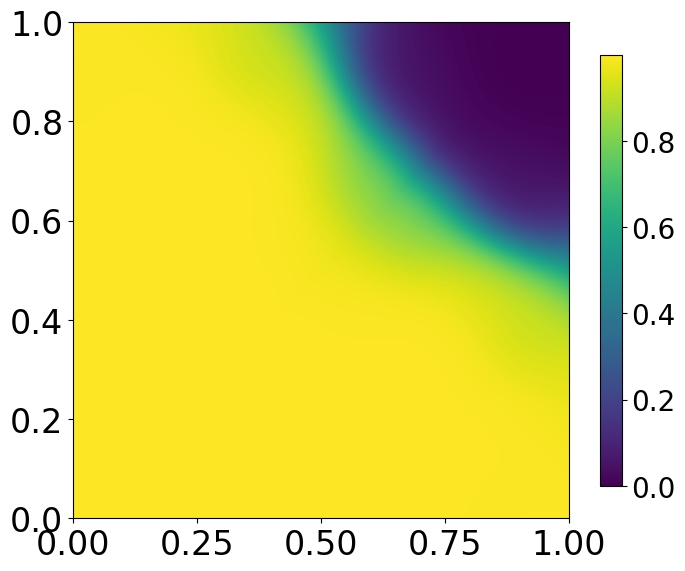

best_model_bp_heawood_DiffNet-Mul_sin_256_5_5e-05.pt
File: best_model_bp_heawood_DiffNet-Mul_sin_256_5_5e-05.pt, Target: 0, Arch: DiffNet-Mul, Act: sin, Width: 256, Layers: 5, LR: 5e-05


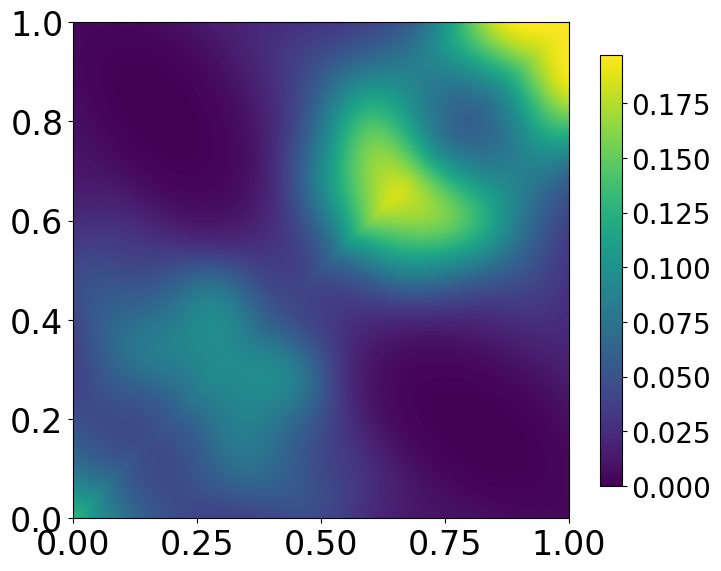

best_model_bp_heawood_DiffNet-Mul_sin_256_5_0.001.pt
File: best_model_bp_heawood_DiffNet-Mul_sin_256_5_0.001.pt, Target: 0, Arch: DiffNet-Mul, Act: sin, Width: 256, Layers: 5, LR: 0.001


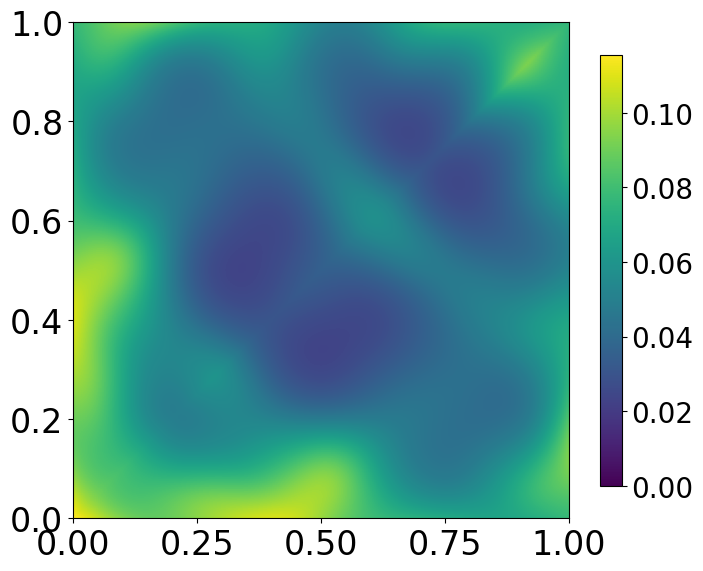

In [5]:
import os

bias_dict = {
  'best_model_bp_heawood_DiffNet-Mul_sin_256_5_0.001.pt': 0.0,
  #'best_model_bp_heawood_DiffNet-Mul_sin_256_5_0.0001.pt': 0.0,
  'best_model_bp_heawood_DiffNet-Mul_sin_256_5_5e-05.pt' : 0.0, # *
  #'best_model_logbp_heawood_DiffNet-Mul_sin_256_5_0.0005.pt': 0.0,
  #'best_model_logbp_heawood_DiffNet-Mul_sin_256_5_0.001.pt': 0.0,
  'best_model_bp_logheawood_DiffNet-Mul_sin_256_5_0.001.pt': 5.0,
}

for file in os.listdir():
  if file.endswith('.pt') and file in bias_dict:
    file_split = file.split('_')
    target = 0
    print(file)

    arch = file_split[4]
    act = file_split[5]
    width = int(file_split[6])
    hid_n_layers = int(file_split[7])
    lr = float(file_split[8][:-3])

    model = construct_model(
      arch=arch,
      train_embed_layer=True,
      act=act,
      width=width,
      hid_n_layers=hid_n_layers,
    )
    model.load_state_dict(torch.load(file, map_location=DEVICE))

    model.to(DEVICE)
    model.eval()

    resolution = 256

    print(f"File: {file}, Target: {target}, Arch: {arch}, Act: {act}, Width: {width}, Layers: {hid_n_layers}, LR: {lr}")
    fig = visualise_learnt_function_f_2d(model, DEVICE, target, 0.000000, target, resolution, bias=bias_dict[file])
    # show
    plt.show()
    data = get_discretised_function_values(model, resolution, 1024, DEVICE, bias=bias_dict[file])

    data = data.numpy()
    np.save(f"{resolution}-discretised_function_values_{file[:-3]}.npy", data)

